<h1 style="font-size:30px;">Introduction to Semantic Segmentation using TensorFlow Hub</h1>

In this notebook, we will learn how to perform semantic image segmentation using pre-trained models available in **TensorFlow Hub**. TensorFlow Hub is a library and platform designed for sharing, discovering, and reusing pre-trained machine learning models. The primary goal of TensorFlow Hub is to simplify the process of reusing existing models, thereby promoting collaboration, reducing redundant work, and accelerating research and development in machine learning. Users can search for pre-trained models, called modules, that have been contributed by the community or provided by Google. These modules can be easily integrated into a user's own machine learning projects with just a few lines of code.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-segmentation-feature-image-NB.png width=850 align='center'><br/>

Image segmentation is a fundamental computer vision task that involves partitioning an image into multiple segments or regions, where each segment corresponds to a specific object, area of interest, or background. By simplifying the representation of an image, segmentation techniques make it easier to analyze and process images for various applications, such as object recognition, tracking, and scene understanding. The goal of image segmentation is to simplify the representation of an image and make it more meaningful for analysis or further processing. You can read more about <a href="https://learnopencv.com/image-segmentation/" target="_blank">Image Segmentation</a> in our introductory post on the subject.

In this example, we will use an image segmentation model <a href="https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1" target="_blank">camvid-hrnetv2-w48</a> that was trained on <a href="https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/" target="_blank">CamVid (Cambridge-driving Labeled Video Database)</a>, which is a driving and scene understanding dataset containing images extracted from five video sequences taken during real-world driving scenarios. The dataset contains 32 classes. Several other image segmentation models can be found <a href="https://tfhub.dev/s?module-type=image-segmentation" target="_blank">here</a> as well.


## Table of Contents
* [1 Download Sample (CamVid) Images](#1-Download-Sample-(CamVid)-Images)
* [2 Model Inference using Tensorflow Hub](#2-Model-Inference-using-Tensorflow-Hub)
* [3 Formalize the Implementation](#3-Formalize-the-Implementation)
* [4 Conclusion](#4-Conclusion)

In [1]:
import os
import numpy as np
import cv2
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 1 Download Sample (CamVid) Images

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "camvid_images.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

### 1.1 Display Sample Images

In [4]:
image_paths = sorted(glob.glob("camvid_images" + os.sep + "*.png"))

for idx in range(len(image_paths)):
    print(image_paths[idx])

camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


In [5]:
def load_image(path):
    image = cv2.imread(path)

    # Convert image in BGR format to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add a batch dimension which is required by the model.
    image = np.expand_dims(image, axis=0) / 255.0

    return image

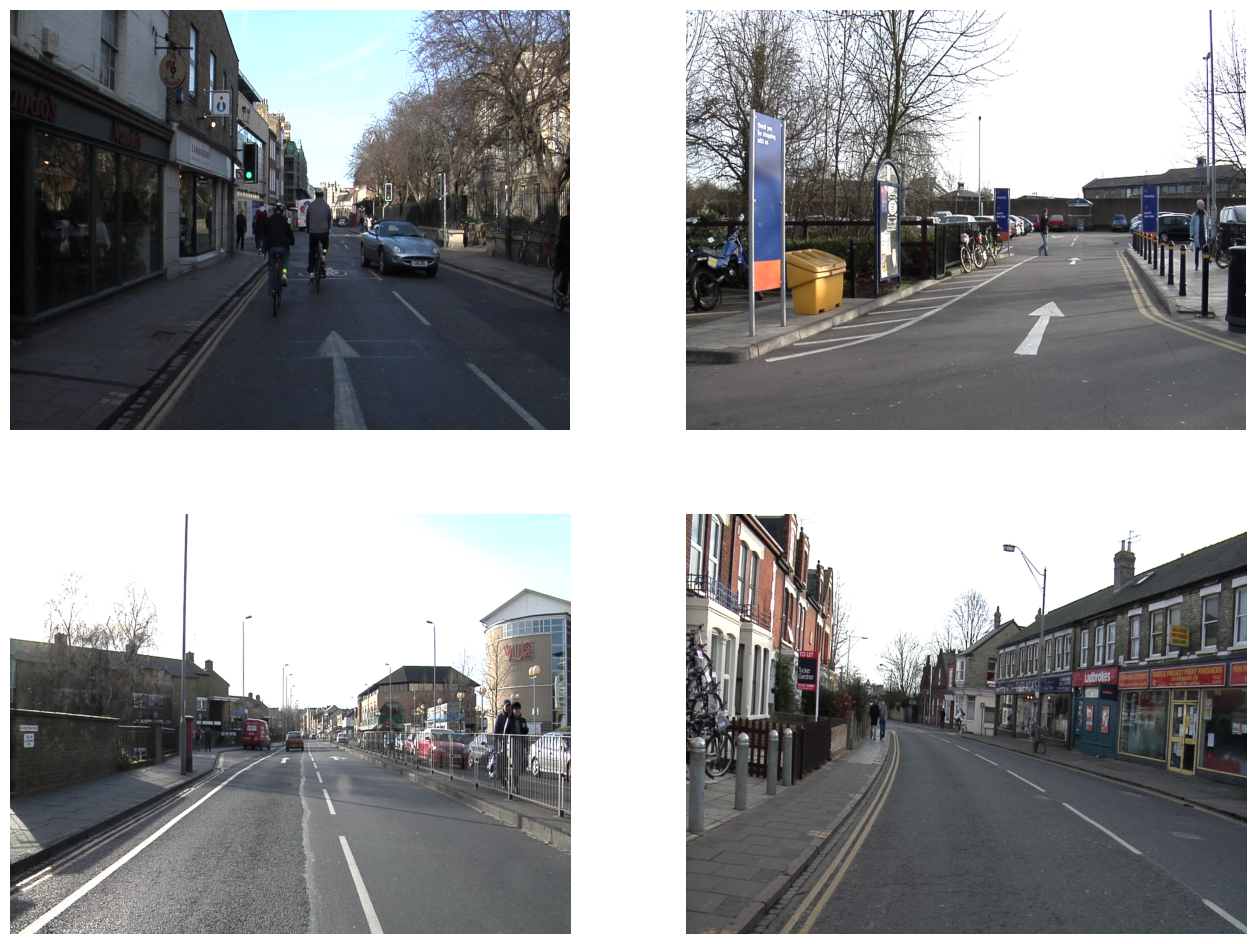

In [6]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis("off")

### 1.2 Define a Dictionary that Maps Class IDs to Class Names and Class Colors

`class_index` is a dictionary that maps all 32 classes in the CamVid dataset with their associated class IDs and RGB color labels.

In [7]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']
    }

## 2 Model Inference using TensorFlow Hub

TensorFlow Hub contains many different pre-trained <a href="https://tfhub.dev/s?module-type=image-segmentation" target="_blank">segmentation models</a>. Here we will use the High-Resolution Network (HRNet) segmentation model trained on CamVid (`camvid-hrnetv2-w48`). The model has been pre-trained on the Imagenet ILSVRC-2012 classification task and fine-tuned on CamVid.

### 2.1 Load the Model from TensorFlow Hub

We can load the model into memory using the url to the model page.

In [8]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print("loading model:", model_url)

seg_model = hub.load(model_url)
print("\nmodel loaded!")

loading model: https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1

model loaded!


### 2.2 Perform Inference

Before we formalize the code to process several images and post-process the results, let's first see how to perform inference on a single image and study the output from the model.

### 2.2.1 Call the Model's `precict()` Method

In [9]:
# Make a prediction using the first image in the list of images.
pred_mask = seg_model.predict(images[0])

# The predicted mask has the following shape: [B, H, W, C].
print("Shape of predicted mask:", pred_mask.shape)

Shape of predicted mask: (1, 720, 960, 33)


### 2.2.2 Post-Process the Predicted Segmentation Mask

The predicted segmentation mask returned by the model contains a separate channel for each class. Each channel contains the probability that a given pixel from the input image is associated with the class for that channel. This data, therefore, requires some post-processing to obtain meaningful results. Several steps need to be performed to arrive at a final visual representation.

1. Remove the batch dimension and the background class.
2. Assign a class label to every pixel in the image based on the highest probability score across all channels.
3. The previous step results in a single-channel image that contains the class labels for each pixel. We, therefore, need to map those class IDs to RGB values so we can visualize the results as a color-coded segmentation map.

#### <font color="CornFlowerBlue">Remove Batch Dimension and Background Class</font>

In [10]:
# Convert tensor to numpy array.
pred_mask = pred_mask.numpy()

# The 1st label is the background class added by the model, but we can remove it for this dataset.
pred_mask = pred_mask[:, :, :, 1:]

# We also need to remove the batch dimension.
pred_mask = np.squeeze(pred_mask)

# Print the shape to confirm: [H, W, C].
print("Shape of predicted mask after removal of batch dimension and background class:", pred_mask.shape)

Shape of predicted mask after removal of batch dimension and background class: (720, 960, 32)


#### <font color="CornFlowerBlue">Visualize the Intermediate Results</font>

(-0.5, 959.5, 719.5, -0.5)

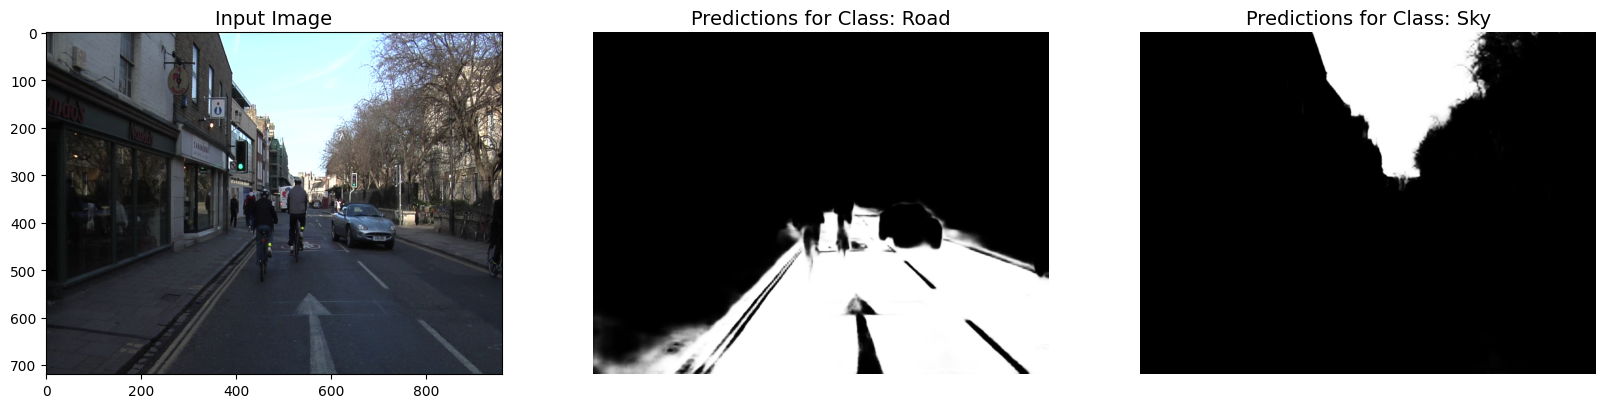

In [11]:
# Each channel in `pred_mask` contains the probabilities that the pixels
# in the original image are associated with the class for that channel.
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image", fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 3, 2)
plt.title("Predictions for Class: Road", fontsize=14)
plt.imshow(pred_mask[:, :, 17], cmap="gray") # Class 17 corresponds to the 'road' class
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predictions for Class: Sky", fontsize=14)
plt.imshow(pred_mask[:, :, 21], cmap="gray") # Class 21 corresponds to the 'sky' class
plt.axis("off")

#### <font color="CornFlowerBlue">Assign Each Pixel a Class Label</font>

Here we assign every pixel in the image with a class ID based on the class with the highest probability. We can visualize this as a grayscale image. In the code cell below, we will display just the top portion of the image to highlight a few of the class asignments.

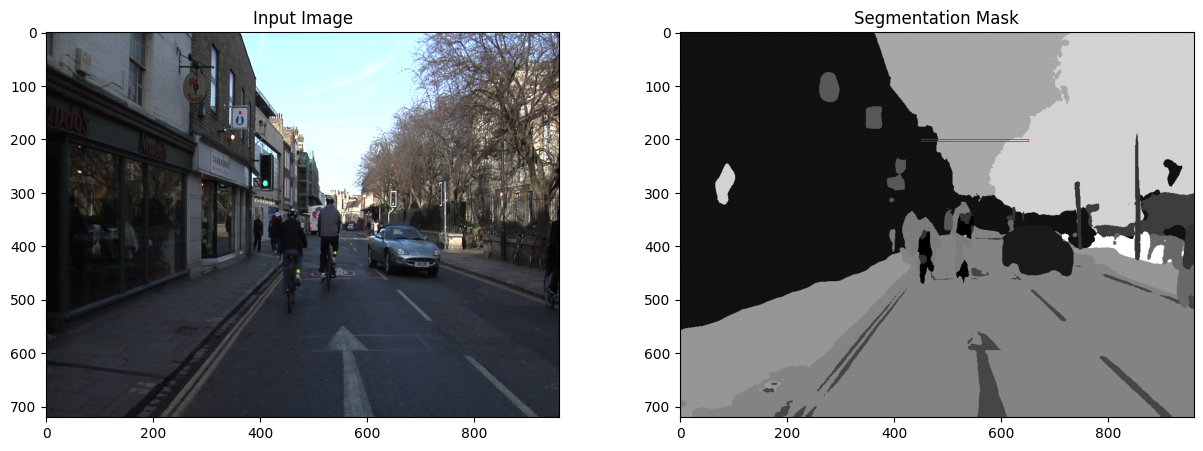

In [12]:
# Assign each pixel in the image a class ID based on the channel that contains the
# highest probability score. This can be implemented using the `argmax` function.
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image", fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask", fontsize=12)
plt.imshow(pred_mask_class, cmap="gray")
plt.gca().add_patch(Rectangle((450, 200), 200, 3, edgecolor="red", facecolor="none", lw=0.5))

Let's now inspect a small region of the segmentation mask to better understand how the values map to class IDs. For reference, the top portion (200 rows) of the segmentation mask (`pred_mask_class`) have been overlayed on the input image. Notice that regions in the segmentation mask correspond to distinct regions in the input image (e.g., buildings, sky, trees).

<img src='https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-segmentation-overlay-zoom.png' width=1000 align='center'><br/>

In [13]:
# Print the class IDs from the last row in the above image.
print(pred_mask_class[200, 450:650])

[ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 26 26 21 21 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26]


#### <font color="CornFlowerBlue">Convert the Single Channel Mask to a Color Representation</font>

We will also need to make use of the function below that will convert a single channel mask to an RGB representation for visualization purposes. Each class ID in the single-channel mask will be converted to a different color according to the `class_index` dictionary mapping.

In [14]:
# Function to convert a single channel mask representation to an RGB mask.
def class_to_rgb(mask_class, class_index):

    # Create RGB channels.
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

Convert the grayscale segmentation mask to a color segmentation mask and display the results.

(-0.5, 959.5, 719.5, -0.5)

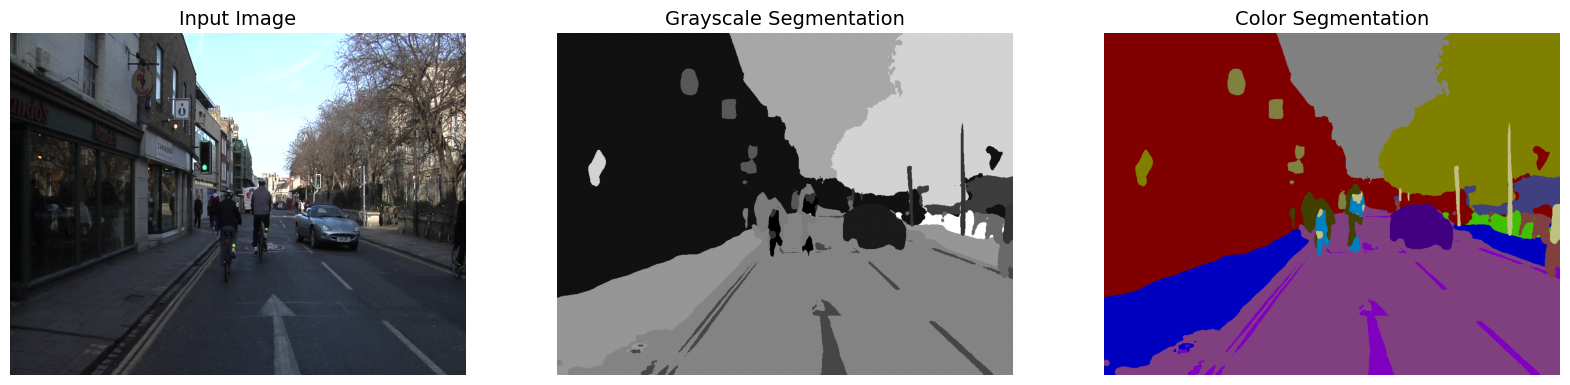

In [15]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.title("Input Image", fontsize=14)
plt.imshow(np.squeeze(images[0]))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grayscale Segmentation", fontsize=14)
plt.imshow(pred_mask_class, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Color Segmentation", fontsize=14)
plt.imshow(pred_mask_rgb, cmap="gray")
plt.axis("off")

## 3 Formalize the Implementation

In this section, we will formalize the implementation and will need to define some additional convenience functions.


### 3.1 `image_overlay()`

`image_overlay()` is a helper function to overlay an RGB mask on top of the original image to better appreciate how the predictions line up with the original image.

In [16]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, seg_map_rgb):

    alpha = 1.0  # Transparency for the original image.
    beta  = 0.6  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    image = (image * 255.0).astype(np.uint8)
    seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

### 3.2 `run_inference()`

To perform inference on several images, we define the function below, which accepts a list of images and a pre-trained model. This function also handles all of the post-processing required to compute the final segmentation mask as well as the overlay.

In [17]:
def run_inference(images, model):
    for img in images:
        # Forward pass through the model (convert the tensor output to a numpy array).
        pred_mask = model.predict(img).numpy()

        # Remove the background class added by the model.
        pred_mask = pred_mask[:, :, :, 1:]

        # Remove the batch dimension.
        pred_mask = np.squeeze(pred_mask)

        # `pred_mask` is a numpy array of shape [H, W, 32] where each channel contains the probability
        # scores associated with a given class. We still need to assign a single class to each pixel
        # which is accomplished using the argmax function across the last dimension to obtain the class labels.
        pred_mask_class = np.argmax(pred_mask, axis=-1)

        # Convert the predicted (class) segmentation map to a color segmentation map.
        pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

        fig = plt.figure(figsize=(20, 15))

        # Display the original image.
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(img[0])
        ax1.title.set_text("Input Image")
        plt.axis("off")

        # Display the predicted color segmentation mask.
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title("Predicted Mask")
        ax2.imshow(pred_mask_rgb)
        plt.axis("off")

        # Display the predicted color segmentation mask overlayed on the original image.
        overlayed_image = image_overlay(img[0], pred_mask_rgb)
        ax4 = fig.add_subplot(1, 3, 3)
        ax4.set_title("Overlayed Image")
        ax4.imshow(overlayed_image)
        plt.axis("off")

        plt.show()

### 3.3 `plot_color_legend()`

The function `plot_color_legend()` creates a color legend for the CamVid dataset, which is helpful for confirming the class assignments by the model.

In [18]:
def plot_color_legend(class_index):
    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)

    # Display color legend.
    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis("off")

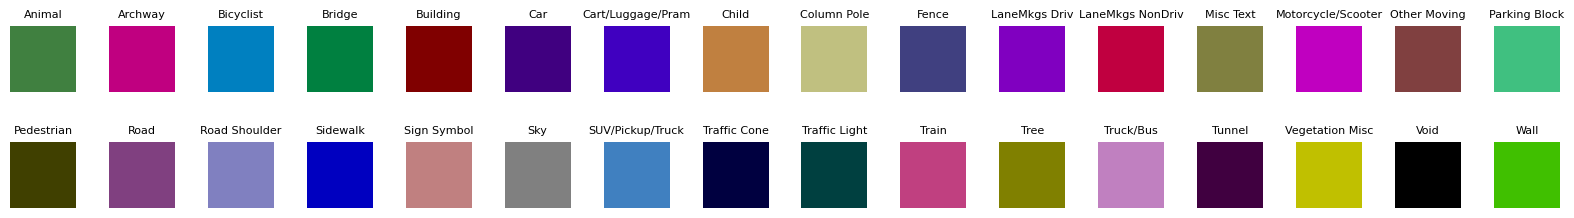

In [ ]:
plot_color_legend(class_index)

### 3.3 Make Predictions on the Sample Images

Now, let's use this function to perform inference on the sample images using the three models we selected above.

In [19]:
run_inference(images, seg_model)

Output hidden; open in https://colab.research.google.com to view.

## 4 Conclusion


In this notebook, we covered how to use pre-trained image segmentation models available in TensorFlow Hub. TensorFlow Hub simplifies the process of reusing existing models by providing a central repository for sharing, discovering, and reusing pre-trained machine learning models. An essential aspect of working with these models involves comprehending the process of interpreting their output. Image segmentation models produce multi-channel segmentation masks, which consist of probability scores that require further processing to generate the final segmentation maps.